<a href="https://colab.research.google.com/github/zfukuoka/image_visual_analysis/blob/master/image_visual_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colaboratory用画像比較分析

Google Colaboratory用の画像比較分析プログラムです。
現在は、CIE xyz比較表示に特化しています。

## 動作に必要なもの

*   Google Colaboratory を使うための Google アカウント
*   Webブラウザ
*   同じ画角で撮影した画像２枚

## 制限事項

*   sRGBの色空間とガンマ2.2を採用したのJPEGファイルのみ正しく動作します
  *  最近のiPhoneはDisplayP3の色空間のため、正しく動作しません
  * ガンマの計算は2.2に固定して、リニア化処理
  * 処理そのものでJPEGのみには制限しておりませんが、正しく動作しない可能性があります
*   画像サイズが大きいと、アップロード時間が増大します
*  一度アップロードした画像ファイルも動作開始時に強制的に削除するので、同じ画像でも再度アップロードが必要です
*   変換する画像からピクセルの間引きを行ったあとに色変換の処理をします
  * 間引きはリサイズによる色の変化（画像にない色を作られること）を避けるために行っており、より良い方法があったときには間引きから変わることがあります
* 処理の基本的なところはGoogle Colaboratory に依存していませんが、Python環境を構築することなく簡単に使えるようにしたかったので画像ファイルのアップロード部分は Google Colaboratory に依存した作りになっています
*   どんなグラフを表示すればわかりやすいかかのように完成形が見えていないため、冗長なコードがあったり、逐次コード変更する可能性があります
 

## 動作方法

唯一のセルを起動後、ファイルアップロードが求められるので、２つ画像ファイルを指定して、後は待つだけ。


Saving st52693_tabijo-02_EX.jpg to st52693_tabijo-02_EX.jpg
Saving st52693_tabijo-02lite_EX.jpg to st52693_tabijo-02lite_EX.jpg
(590, 442) RGB


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in double_scalars


(590, 442) RGB


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(0.0, 0.7)

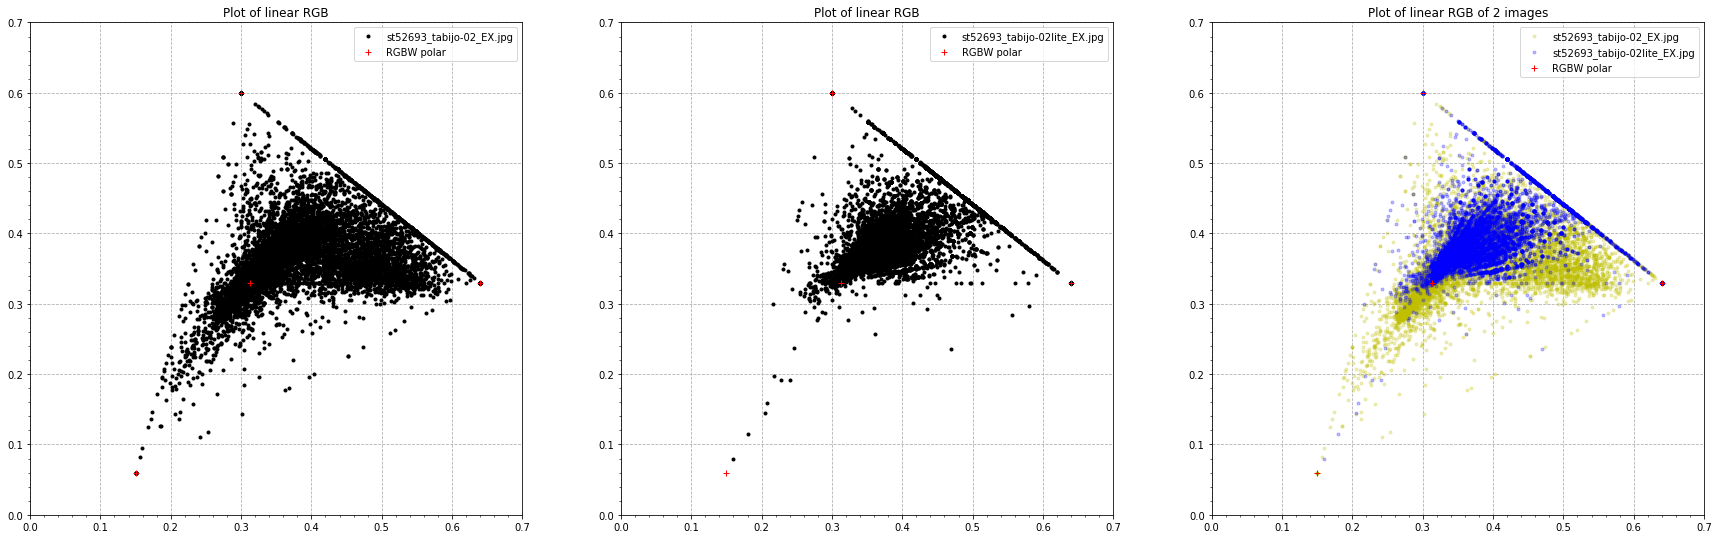

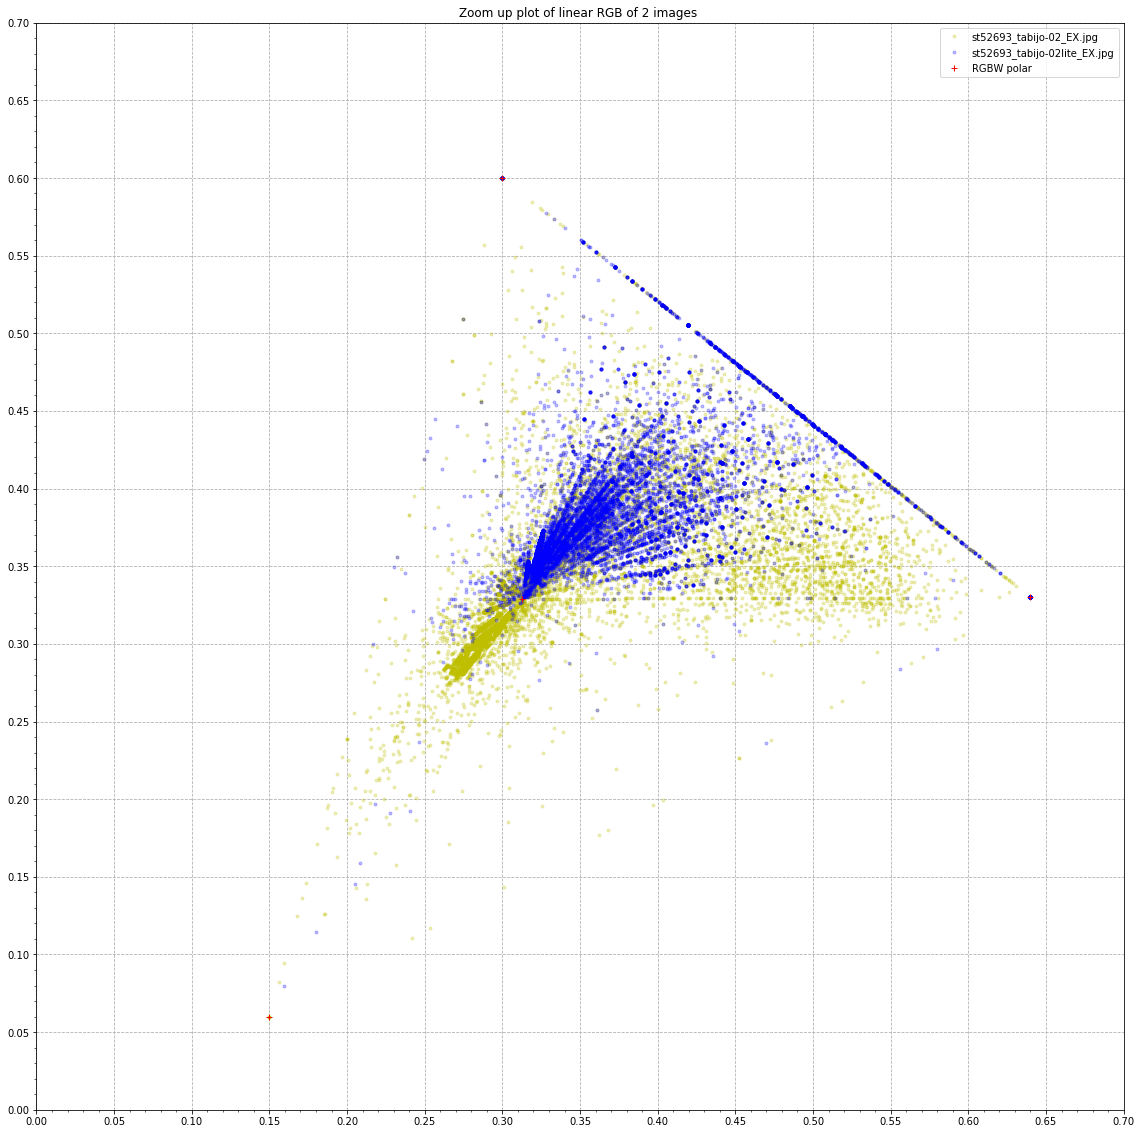

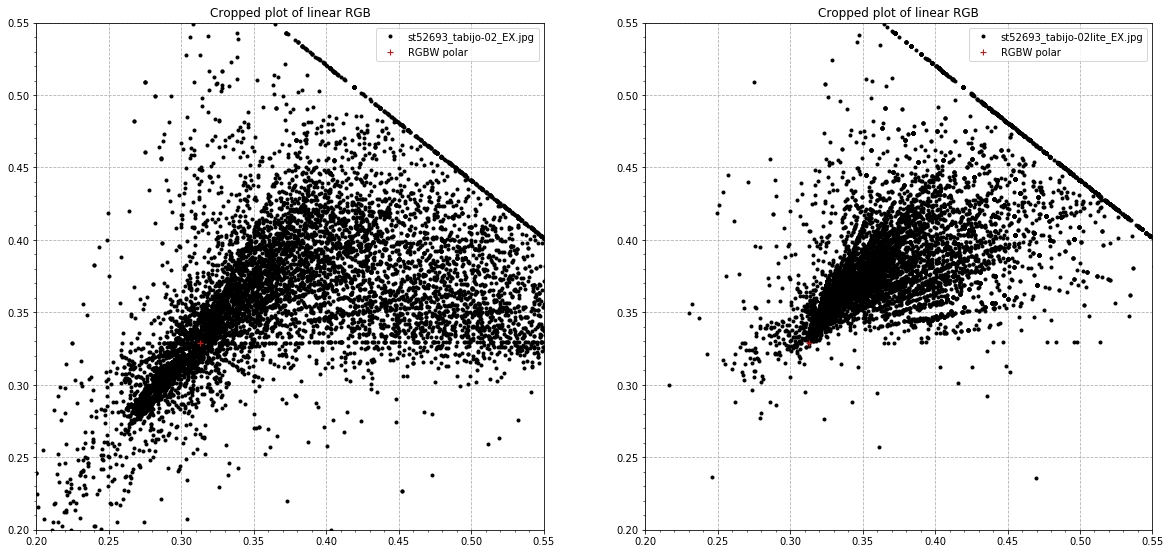

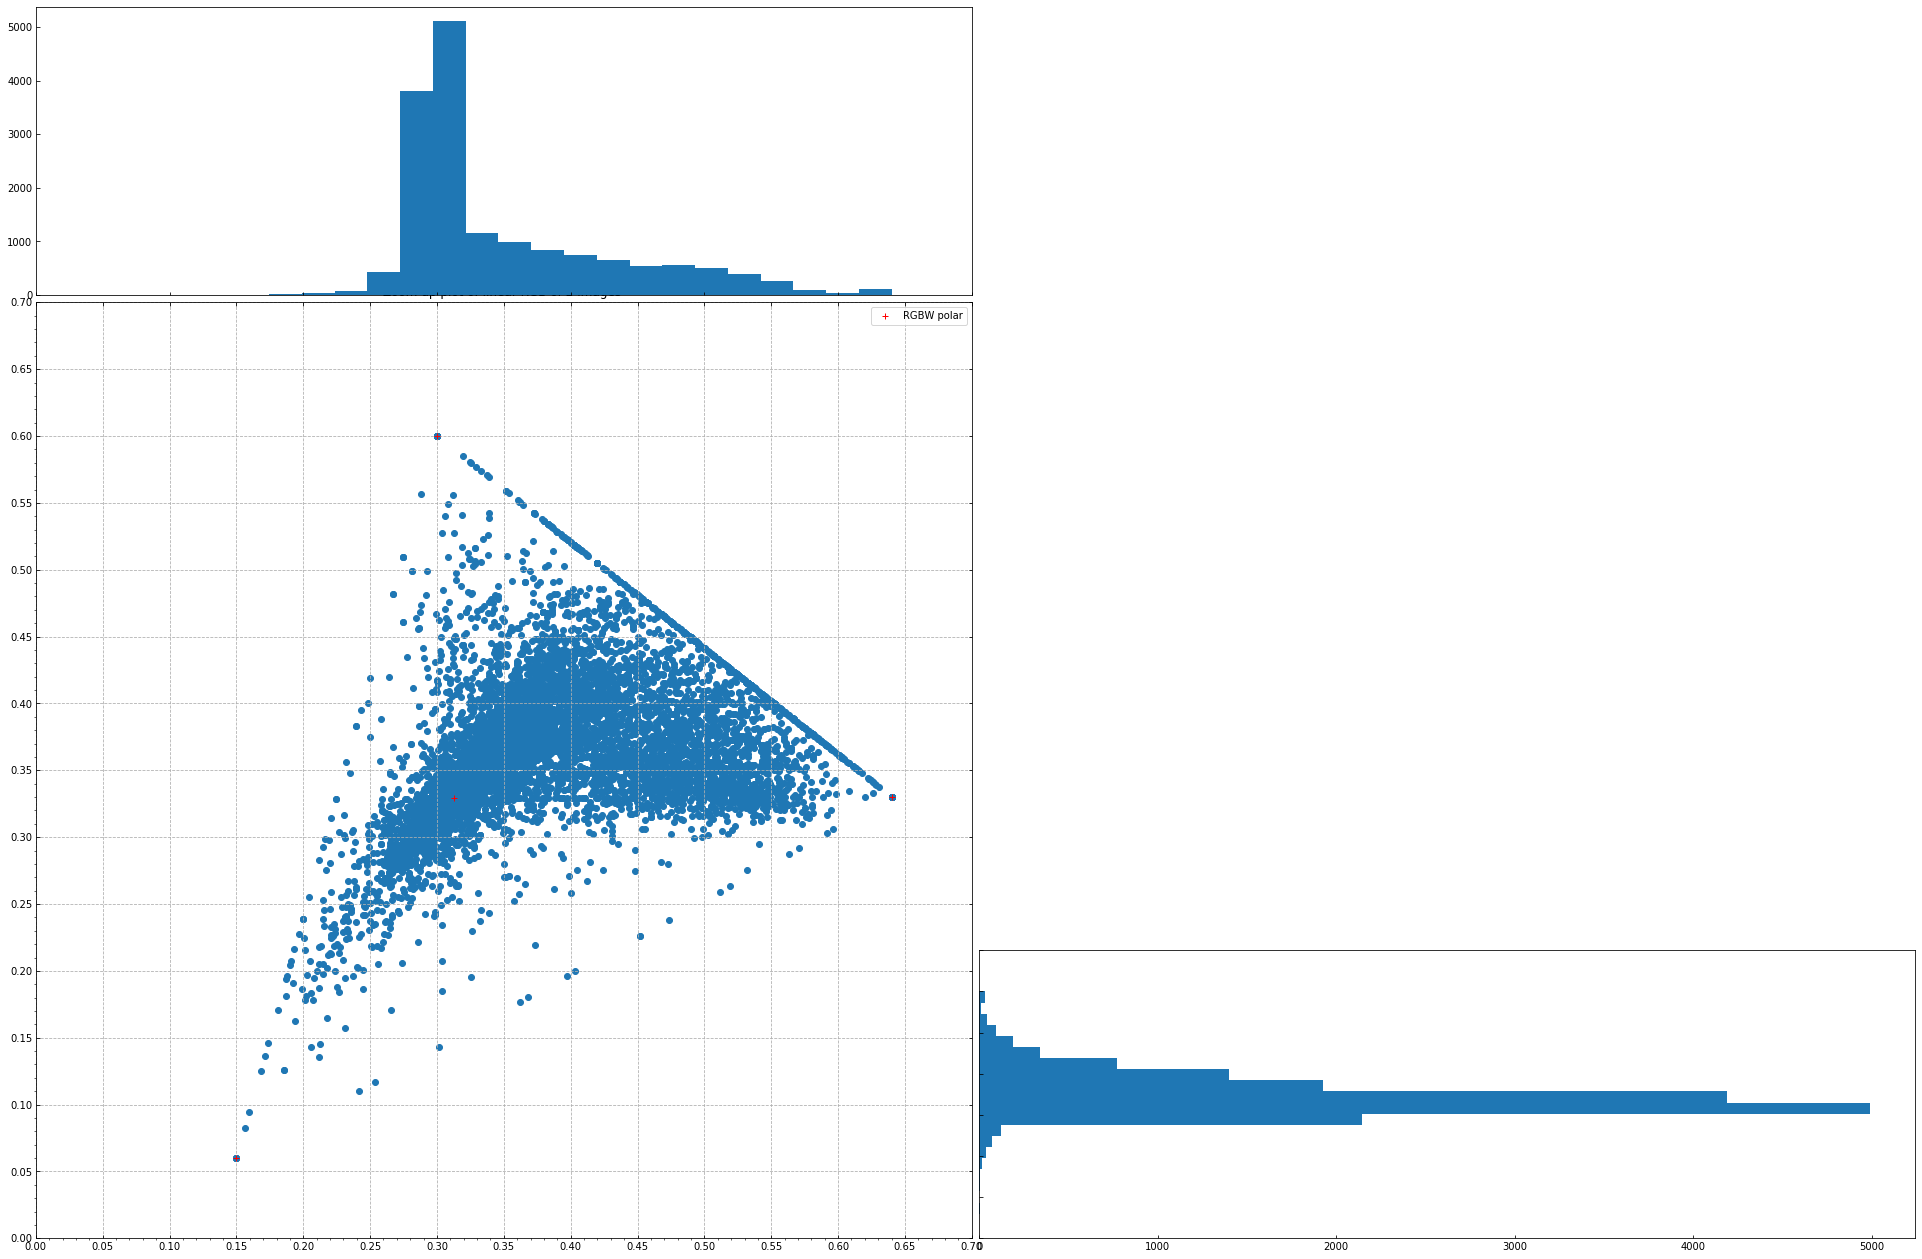

In [10]:
# -*- coding: utf-8 -*-

# import libraries
import sys
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from google.colab import files

POLARS = np.array([[0.64, 0.33], [0.30, 0.60], [0.15, 0.06], [0.3127, 0.3290]])
PLOT_X_LIM = 0, 0.7        # グラフの表現範囲でX軸の下限、上限
PLOT_Y_LIM = 0, 0.7        # グラフの表現範囲でY軸の下限、上限
MAJOR_LOCATOR = 0.1        # グラフのMajorなメモリ間隔
MINOR_LOCATOR_DIVIDER = 5  # グラフのMinor(Majorの分割数)なメモリ設定値

# Jpeg files load from local PC.
# When not specified 2 jpeg files, it force to end.
!rm *.jpg
uploaded_images = files.upload()

if(len(uploaded_images) != 2):
  print("This program requires 2 image files. So, please retry again.")
  sys.exit(1)

ims = list()
im_fnames = list()
for k, v in uploaded_images.items():
  ims.append(Image.open(k, mode='r'))
  im_fnames.append(k)


def normalizeRgb(originPixel):
  # JPEGを前提として、RGBの各々の解像度8bit(255)と定義
  RGB_RESOLUTION = 255

  # 0～1の間で正規化
  tempPixel = originPixel / RGB_RESOLUTION

  # ガンマ補正を元に戻し、リニア化
  #   正規化値  <= 0.04045 : 正規化値 / 12.92
  #   正規化値  >  0.04045 : ((正規化値 + 0.055) / 1.055) に 2.4階乗
  LINEAR_THR = 0.04045
  return np.piecewise(
      tempPixel,
      [tempPixel <= LINEAR_THR, tempPixel > LINEAR_THR],
      [lambda tempPixel: tempPixel/12.92, lambda tempPixel: ((tempPixel+0.055)/1.055)**2.4])

# convert from normalized RGB to CIE XYZ
def convertToCieXYZ(normalizedRgb):
  # RGB of sRGB color space to CIE XYZ convert matrix
  MATRIX = np.array(
      [[0.412424, 0.357579, 0.180464],
       [0.212656, 0.715158, 0.072186],
       [0.019332, 0.119193, 0.950444]],
       dtype='float32')

  # 画像を１次元に並べ、ループで画素毎にRGBからXYZを算出
  ret_arr = np.empty((0,3), dtype='float32')
  temp = normalizedRgb.reshape(-1, 3)
  (number, _) = temp.shape

  for i in range(number):
    ret_arr = np.append(ret_arr, np.dot(MATRIX, temp[i]).reshape(1,3), axis=0)

  return ret_arr
# convert from CIE XYZ to CIE xyz 
def convertToCiexyz(cieXYZ):
  # ループで画素毎にXYZからxyzを算出
  #   x = X / (X + Y + Z)
  #   y = Y / (X + Y + Z)
  #   z = Z / (X + Y + Z)
  ret_arr = np.empty((0,3), dtype='float32')
  (number, _) = cieXYZ.shape

  for i in range(number):
    xyz = np.array(
        [cieXYZ[i][0]/np.sum(cieXYZ[i]),
         cieXYZ[i][1]/np.sum(cieXYZ[i]),
         cieXYZ[i][2]/np.sum(cieXYZ[i])])
    ret_arr = np.append(ret_arr, xyz.reshape(1,3), axis=0)

  return ret_arr


ciexyzs = list()
for im in ims:
  print(im.size, im.mode)
  im_list = np.asarray(im)

  # 画像の間引き：とりあえず、XGA以上の解像度を想定し、横幅1024未満にする間引き
  MAX_IMG_WIDTH = 1024
  (img_x, img_y, img_dim) = im_list.shape
  if img_x  > img_y:
    skip = int(img_x / MAX_IMG_WIDTH) + 1
  else:
    skip = int(img_y / MAX_IMG_WIDTH) + 1

  # 処理時間がかかるため、追加で固定値で間引き
  skip *= 4
  im_list2 = im_list[::skip,::skip,::]

  # RGB to CIE xyz
  normalizedRGB = normalizeRgb(im_list2)
  cieXYZ = convertToCieXYZ(normalizedRGB)
  ciexyzs.append(convertToCiexyz(cieXYZ))

image1_x = ciexyzs[0][0:, 0]
image1_y = ciexyzs[0][0:, 1]
image2_x = ciexyzs[1][0:, 0]
image2_y = ciexyzs[1][0:, 1]
image1_filename = im_fnames[0]
image2_filename = im_fnames[1]

# プロット1 リニアRGBの比較
fig = plt.figure(figsize=(30,10))
ax_plot1 = fig.add_subplot(131)
ax_plot1.set_title('Plot of linear RGB')
ax_plot1.set_xlim(PLOT_X_LIM)
ax_plot1.set_ylim(PLOT_Y_LIM)
ax_plot1.xaxis.set_major_locator(MultipleLocator(MAJOR_LOCATOR))
ax_plot1.yaxis.set_major_locator(MultipleLocator(MAJOR_LOCATOR))
ax_plot1.grid(linestyle="--", zorder=-10)
ax_plot1.xaxis.set_minor_locator(AutoMinorLocator(MINOR_LOCATOR_DIVIDER))
ax_plot1.yaxis.set_minor_locator(AutoMinorLocator(MINOR_LOCATOR_DIVIDER))
ax_plot1.set_aspect('equal')
ax_plot1.plot(image1_x, image1_y, 'k.', alpha=1.0, label=image1_filename)
ax_plot1.plot(POLARS[0:,0], POLARS[0:,1], "r+", label="RGBW polar")
ax_plot1.legend()

ax_plot2 = fig.add_subplot(132)
ax_plot2.set_title('Plot of linear RGB')
ax_plot2.set_xlim(PLOT_X_LIM)
ax_plot2.set_ylim(PLOT_Y_LIM)
ax_plot2.xaxis.set_major_locator(MultipleLocator(MAJOR_LOCATOR))
ax_plot2.yaxis.set_major_locator(MultipleLocator(MAJOR_LOCATOR))
ax_plot2.grid(linestyle="--", zorder=-10)
ax_plot2.xaxis.set_minor_locator(AutoMinorLocator(MINOR_LOCATOR_DIVIDER))
ax_plot2.yaxis.set_minor_locator(AutoMinorLocator(MINOR_LOCATOR_DIVIDER))
ax_plot2.set_aspect('equal')
ax_plot2.plot(image2_x, image2_y, 'k.', alpha=1.0, label=image2_filename)
ax_plot2.plot(POLARS[0:,0], POLARS[0:,1], "r+", label="RGBW polar")
ax_plot2.legend()

ax_plot3 = fig.add_subplot(133)
ax_plot3.set_title('Plot of linear RGB of 2 images')
ax_plot3.set_xlim(PLOT_X_LIM)
ax_plot3.set_ylim(PLOT_Y_LIM)
ax_plot3.xaxis.set_major_locator(MultipleLocator(MAJOR_LOCATOR))
ax_plot3.yaxis.set_major_locator(MultipleLocator(MAJOR_LOCATOR))
ax_plot3.grid(linestyle="--", zorder=-10)
ax_plot3.xaxis.set_minor_locator(AutoMinorLocator(MINOR_LOCATOR_DIVIDER))
ax_plot3.yaxis.set_minor_locator(AutoMinorLocator(MINOR_LOCATOR_DIVIDER))
ax_plot3.set_aspect('equal')
ax_plot3.plot(image1_x, image1_y, 'y.', alpha=0.25, label=image1_filename)
ax_plot3.plot(image2_x, image2_y, 'b.', alpha=0.25, label=image2_filename)
ax_plot3.plot(POLARS[0:,0], POLARS[0:,1], "r+", label="RGBW polar")
ax_plot3.legend()

fig2 = plt.figure(figsize=(20,20))
ax_plot4 = fig2.add_subplot(111)
ax_plot4.set_title('Zoom up plot of linear RGB of 2 images ')
ax_plot4.set_xlim(PLOT_X_LIM)
ax_plot4.set_ylim(PLOT_Y_LIM)
ax_plot4.xaxis.set_major_locator(MultipleLocator(MAJOR_LOCATOR/2))
ax_plot4.yaxis.set_major_locator(MultipleLocator(MAJOR_LOCATOR/2))
ax_plot4.grid(linestyle="--", zorder=-10)
ax_plot4.xaxis.set_minor_locator(AutoMinorLocator(MINOR_LOCATOR_DIVIDER))
ax_plot4.yaxis.set_minor_locator(AutoMinorLocator(MINOR_LOCATOR_DIVIDER))
ax_plot4.set_aspect('equal')
ax_plot4.plot(image1_x, image1_y, 'y.', alpha=0.25, label=image1_filename)
ax_plot4.plot(image2_x, image2_y, 'b.', alpha=0.25, label=image2_filename)
ax_plot4.plot(POLARS[0:,0], POLARS[0:,1], "r+", label="RGBW polar")
ax_plot4.legend()

fig3 = plt.figure(figsize=(20,20))
PLOTZOOM_X_LIM = 0.2, 0.55        # グラフの表現範囲でX軸の下限、上限
PLOTZOOM_Y_LIM = 0.2, 0.55        # グラフの表現範囲でY軸の下限、上限
ax_plot5 = fig3.add_subplot(121)
ax_plot5.set_title('Cropped plot of linear RGB')
ax_plot5.set_xlim(PLOTZOOM_X_LIM)
ax_plot5.set_ylim(PLOTZOOM_Y_LIM)
ax_plot5.xaxis.set_major_locator(MultipleLocator(MAJOR_LOCATOR/2))
ax_plot5.yaxis.set_major_locator(MultipleLocator(MAJOR_LOCATOR/2))
ax_plot5.grid(linestyle="--", zorder=-10)
ax_plot5.xaxis.set_minor_locator(AutoMinorLocator(MINOR_LOCATOR_DIVIDER))
ax_plot5.yaxis.set_minor_locator(AutoMinorLocator(MINOR_LOCATOR_DIVIDER))
ax_plot5.set_aspect('equal')
ax_plot5.plot(image1_x, image1_y, 'k.', alpha=1.0, label=image1_filename)
ax_plot5.plot(POLARS[0:,0], POLARS[0:,1], "r+", label="RGBW polar")
ax_plot5.legend()

ax_plot6 = fig3.add_subplot(122)
ax_plot6.set_title('Cropped plot of linear RGB')
ax_plot6.set_xlim(PLOTZOOM_X_LIM)
ax_plot6.set_ylim(PLOTZOOM_Y_LIM)
ax_plot6.xaxis.set_major_locator(MultipleLocator(MAJOR_LOCATOR/2))
ax_plot6.yaxis.set_major_locator(MultipleLocator(MAJOR_LOCATOR/2))
ax_plot6.grid(linestyle="--", zorder=-10)
ax_plot6.xaxis.set_minor_locator(AutoMinorLocator(MINOR_LOCATOR_DIVIDER))
ax_plot6.yaxis.set_minor_locator(AutoMinorLocator(MINOR_LOCATOR_DIVIDER))
ax_plot6.set_aspect('equal')
ax_plot6.plot(image2_x, image2_y, 'k.', alpha=1.0, label=image2_filename)
ax_plot6.plot(POLARS[0:,0], POLARS[0:,1], "r+", label="RGBW polar")
ax_plot6.legend()

fig4 = plt.figure(figsize=(15,15))
LEFT, WIDTH = 0.1, 0.65
BOTTOM, HEIGHT = 0.1, 0.65
SPACING = 0.005
RECT_SCATTER = [LEFT, BOTTOM, WIDTH, HEIGHT]
RECT_HISTX = [LEFT, BOTTOM + HEIGHT + SPACING, WIDTH, 0.2]
RECT_HISTY = [LEFT + WIDTH + SPACING, BOTTOM, WIDTH, 0.2]
ax_plot7 = fig4.add_axes(RECT_SCATTER)
ax_plot7.tick_params(direction='in', top=True, right=True)
ax_hist1 = fig4.add_axes(RECT_HISTX)
ax_hist1.tick_params(direction='in', labelbottom=False)
ax_hist2 = fig4.add_axes(RECT_HISTY)
ax_hist2.tick_params(direction='in', labelleft=False)

ax_plot7.set_title('Zoom up plot of linear RGB of 2 images ')
ax_plot7.set_xlim(PLOT_X_LIM)
ax_plot7.set_ylim(PLOT_Y_LIM)
ax_plot7.xaxis.set_major_locator(MultipleLocator(MAJOR_LOCATOR/2))
ax_plot7.yaxis.set_major_locator(MultipleLocator(MAJOR_LOCATOR/2))
ax_plot7.grid(linestyle="--", zorder=-10)
ax_plot7.xaxis.set_minor_locator(AutoMinorLocator(MINOR_LOCATOR_DIVIDER))
ax_plot7.yaxis.set_minor_locator(AutoMinorLocator(MINOR_LOCATOR_DIVIDER))
ax_plot7.set_aspect('equal')
ax_plot7.scatter(image1_x, image1_y)
ax_plot7.plot(POLARS[0:,0], POLARS[0:,1], "r+", label="RGBW polar")
ax_plot7.legend()
ax_hist1.hist(image1_x, bins=20)
ax_hist1.set_xlim(ax_plot7.get_xlim())
ax_hist2.hist(image1_y, bins=20, orientation='horizontal')
ax_hist2.set_ylim(ax_plot7.get_ylim())
